## Import necessary 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import time
import random
import os
import dataset


print("Pytorch Version :", torch.__version__)  # Pytorch Version : 2.0.1+cpu

writer = SummaryWriter('runs/Scenario_Classfication')

Pytorch Version : 2.0.1+cpu


## transfer learning

In [2]:
retrain = False
path = os.getcwd()
dir_ = 'model'
checkpoint_name = ''

In [3]:
if retrain:
    checkpoint_path = os.path.join(path, dir_ , checkpoint_name)
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(checkpoint_path)

# Hyperparameters

In [4]:
# random seed
random_seed = 42
num_epoch = 25
batch_size = 64
in_channels = 1
num_classes = 4
num_layers = 2
fully_connected = 128
lr = 0.01

weight_decay = 0.001

# Parameters
view_train_iter = 100
view_val_iter = 5
save_point = 0.90

### Random Seed

In [5]:
def torch_random_seed(on_seed=False, random_seed=1):
    if on_seed:
        torch.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        np.random.seed(random_seed)
        random.seed(random_seed)
        
torch_random_seed(on_seed=True, random_seed=random_seed)

## Model Evaluation Function

In [6]:
def get_clf_eval(y_true, y_pred, average='weighted'):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=average, warn_for=tuple())
    return accuracy, precision, recall, f1

## Load dataset

In [7]:
columns, data = dataset.import_from_files()
print("\nColumns :", columns.shape, sep=" ")
print("Data :", data.shape, sep=" ")

./dataset/Glass\1.csv
./dataset/Glass\10.csv
./dataset/Glass\11.csv
./dataset/Glass\12.csv
./dataset/Glass\13.csv
./dataset/Glass\14.csv
./dataset/Glass\2.csv
./dataset/Glass\3.csv
./dataset/Glass\4.csv
./dataset/Glass\5.csv
./dataset/Glass\6.csv
./dataset/Glass\7.csv
./dataset/Glass\8.csv
./dataset/Glass\9.csv
./dataset/LOS\1.csv
./dataset/LOS\10.csv
./dataset/LOS\11.csv
./dataset/LOS\12.csv
./dataset/LOS\13.csv
./dataset/LOS\14.csv
./dataset/LOS\2.csv
./dataset/LOS\3.csv
./dataset/LOS\4.csv
./dataset/LOS\5.csv
./dataset/LOS\6.csv
./dataset/LOS\7.csv
./dataset/LOS\8.csv
./dataset/LOS\9.csv
./dataset/Metal\1.csv
./dataset/Metal\10.csv
./dataset/Metal\11.csv
./dataset/Metal\12.csv
./dataset/Metal\13.csv
./dataset/Metal\14.csv
./dataset/Metal\2.csv
./dataset/Metal\3.csv
./dataset/Metal\4.csv
./dataset/Metal\5.csv
./dataset/Metal\6.csv
./dataset/Metal\7.csv
./dataset/Metal\8.csv
./dataset/Metal\9.csv
./dataset/Wall\1.csv
./dataset/Wall\10m.csv
./dataset/Wall\11m.csv
./dataset/Wall\12m.csv

In [8]:
print(data)
print(columns)

[[  1.      1.501 -58.      1.   ]
 [  1.      1.54  -55.      1.   ]
 [  1.      1.54  -55.      1.   ]
 ...
 [  9.     10.764 -80.      3.   ]
 [  9.     10.764 -80.      3.   ]
 [  9.     10.569 -80.      3.   ]]
['True Range' 'RTT' 'RSSI' 'Scenario']


### Create Pandas Dataframe 

In [9]:
df_final = pd.DataFrame(data=data, columns=columns)
df_final.head()

,True Range,RTT,RSSI,Scenario
0,1.0,1.501,-58.0,1.0
1,1.0,1.540,-55.0,1.0
2,1.0,1.540,-55.0,1.0
3,1.0,1.501,-54.0,1.0
4,1.0,1.423,-53.0,1.0


### Check for rows with NaN values in specific columns

In [10]:
selected_columns = ['RTT', 'RSSI'] 
nan_rows = df_final[df_final[selected_columns].isnull().any(axis=1)]
print(nan_rows)

      True Range  RTT  RSSI  Scenario
8685         NaN  NaN   NaN       2.0
8686         NaN  NaN   NaN       2.0
8687         NaN  NaN   NaN       2.0
8688         NaN  NaN   NaN       2.0
8689         NaN  NaN   NaN       2.0
8690         NaN  NaN   NaN       2.0
8691         NaN  NaN   NaN       2.0
8692         NaN  NaN   NaN       2.0
8693         NaN  NaN   NaN       2.0
8694         NaN  NaN   NaN       2.0
8695         NaN  NaN   NaN       2.0
8696         NaN  NaN   NaN       2.0
8697         NaN  NaN   NaN       2.0
8698         NaN  NaN   NaN       2.0
8699         NaN  NaN   NaN       2.0
8700         NaN  NaN   NaN       2.0
8701         NaN  NaN   NaN       2.0
8702         NaN  NaN   NaN       2.0
8703         NaN  NaN   NaN       2.0


In [11]:
# Remove rows with NaN values in specific columns
df_final = df_final.dropna(subset=selected_columns)
df_final

,True Range,RTT,RSSI,Scenario
0,1.0,1.501,-58.0,1.0
1,1.0,1.540,-55.0,1.0
2,1.0,1.540,-55.0,1.0
3,1.0,1.501,-54.0,1.0
4,1.0,1.423,-53.0,1.0
...,...,...,...,...
12190,9.0,10.569,-79.0,3.0
12191,9.0,10.647,-79.0,3.0
12192,9.0,10.764,-80.0,3.0
12193,9.0,10.764,-80.0,3.0


In [12]:
# LOS/NLOS Count
glass_count = df_final.query("Scenario == 0")["Scenario"].count()
los_count = df_final.query("Scenario == 1")["Scenario"].count()
metal_count = df_final.query("Scenario == 2")["Scenario"].count()
wall_count = df_final.query("Scenario == 3")["Scenario"].count()

print("Line of Sight Count :", los_count)
print("Glass Count :", glass_count)
print("Metal Count :", metal_count)
print("Wall Count :", wall_count)

Line of Sight Count : 3243
Glass Count : 2852
Metal Count : 3017
Wall Count : 3064


In [13]:
selected_columns = ['RTT', 'RSSI'] 
df_final_data = df_final[selected_columns]
df_final_data

,RTT,RSSI
0,1.501,-58.0
1,1.540,-55.0
2,1.540,-55.0
3,1.501,-54.0
4,1.423,-53.0
...,...,...
12190,10.569,-79.0
12191,10.647,-79.0
12192,10.764,-80.0
12193,10.764,-80.0


### train test dataset split and preprocessing

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_final_data.values, df_final['Scenario'].values, test_size=0.1, random_state=42, stratify=df_final['Scenario'].values)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=random_seed, stratify=y_train)

print("x_train shape, y_train_Shape :", x_train.shape, y_train.shape)
print("x_val shape, y_val_shape :", x_val.shape, y_val.shape)
print("x_test shape, y_test_shape :", x_test.shape, y_test.shape)
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()
# Fit on training data and transform it
x_train = scaler.fit_transform(x_train)

# Transform validation and test sets using the same scaler
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

print("x_train shape, y_train_Shape :", x_train.shape, y_train.shape)
print("x_val shape, y_val_shape :", x_val.shape, y_val.shape)
print("x_test shape, y_test_shape :", x_test.shape, y_test.shape)

x_train shape, y_train_Shape : (9862, 2) (9862,)
x_val shape, y_val_shape : (1096, 2) (1096,)
x_test shape, y_test_shape : (1218, 2) (1218,)
x_train shape, y_train_Shape : (9862, 2) (9862,)
x_val shape, y_val_shape : (1096, 2) (1096,)
x_test shape, y_test_shape : (1218, 2) (1218,)


## Dataset & DataLoader

In [15]:
def generating_loader(x_data, y_data, batch_size=batch_size, shuffle=True, drop_last=True):
    # preprocessing x_data
    x_data = np.expand_dims(x_data, axis=1)
    x_tensor = torch.tensor(x_data, dtype=torch.float32)
    # preprocessing y_data
    y_tensor = torch.tensor(y_data, dtype=torch.long).view(-1)

    return DataLoader(TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)


In [16]:
trainloader = generating_loader(x_train, y_train, batch_size=batch_size, shuffle=True, drop_last=True)
validationloader = generating_loader(x_val, y_val, batch_size=batch_size, shuffle=False, drop_last=True)
testloader = generating_loader(x_val, y_val, batch_size=batch_size, shuffle=False, drop_last=True)

print("Train  0 count :", len(y_train[y_train==0]))
print("Train 1 count :", len(y_train[y_train==1]))
print("Train  2 count :", len(y_train[y_train==2]))
print("Train 3 count :", len(y_train[y_train==3]))
print("Validation  0 count :", len(y_val[y_val==0]))
print("Validation 1 count :", len(y_val[y_val==1]))
print("Validation  2 count :", len(y_val[y_val==2]))
print("Validation 3 count :", len(y_val[y_val==3]))
print("Test NLOS 0 count :", len(y_test[y_test==0]))
print("Test NLOS 1 count :", len(y_test[y_test==1]))
print("Test NLOS 2 count :", len(y_test[y_test==2]))
print("Test NLOS 3 count :", len(y_test[y_test==3]))

Train  0 count : 2310
Train 1 count : 2627
Train  2 count : 2444
Train 3 count : 2481
Validation  0 count : 257
Validation 1 count : 292
Validation  2 count : 271
Validation 3 count : 276
Test NLOS 0 count : 285
Test NLOS 1 count : 324
Test NLOS 2 count : 302
Test NLOS 3 count : 307


In [17]:
for x, label in trainloader:
    print(x.shape, label.shape)
    break

torch.Size([64, 1, 2]) torch.Size([64])


### Create Model

In [18]:
import torch.nn.functional as F

class CNN_LSTM(nn.Module):
    def __init__(self, in_channels, out_channels, batch_size, num_layers, fully_connected, device):
        super(CNN_LSTM, self).__init__()
        self.batch_size = batch_size
        
        self.conv1d_layer = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # Max-pooling layer after the convolutions
        )
        # LSTM layers
        
        self.lstm1 = nn.LSTM(input_size=1, hidden_size=8, num_layers=num_layers, bias=False, dropout=0.5, bidirectional=True, batch_first=True)
       
        
        self.hidden_state1, self.cell_state1 = self.init_hidden()
         
        self.bn0 = nn.BatchNorm1d(16)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.fc_layer = nn.Linear(16, 32)
        self.relu = nn.ReLU()
        self.fc_layer_class = nn.Linear(32, out_channels)

    def init_hidden(self):
        hidden_state = torch.zeros(num_layers*2, self.batch_size, 8).to(device)
        cell_state = torch.zeros(num_layers*2, self.batch_size, 8).to(device)
        return hidden_state, cell_state

    def forward(self, x):
        x = self.conv1d_layer(x)
        x, _ = self.lstm1(x, (self.hidden_state1, self.cell_state1))    
        x = x[:, -1:].view(x.size(0), -1)
        x = self.bn0(x)
        x = self.fc_layer(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc_layer_class(x)
        x = F.softmax(x, dim=1)
        # x = self.relu(x)
        return x

### Loss FUnction and Optimizer

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN_LSTM(
    in_channels=in_channels,\
    device=device,\
    out_channels=num_classes,\
    batch_size=batch_size,\
    fully_connected=fully_connected,\
    num_layers=num_layers).to(device)
loss_function = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # optimizer
# tensorboard
images, labels = next(iter(trainloader))
writer.add_graph(model, images.to(device))

### Train and Validation

In [20]:
start = time.time()
correct = 0
total = 0
train_acc = []
tmp_acc = 0
loss_arr = []

print("*Train Start!!*")
if torch.cuda.device_count() == True:
    print("epoch : {}, learing rate : {}, device : {}".format(num_epoch, lr, torch.cuda.get_device_name(0)))
    print("Model : {}".format(model._get_name()))
    print("Loss function : {}".format(loss_function._get_name()))
    print("Optimizer : {}".format(str(optimizer).replace("\n", " ").replace("     ", ", ")))
else:
    print("epoch : {}, learing rate : {}, device : {}".format(num_epoch, lr, device))
    print("Model : {}".format(model._get_name()))
    print("Loss function : {}".format(loss_function._get_name()))
    print("Optimizer : {}".format(str(optimizer).replace("\n", " ").replace("     ", ", ")))
print("*"*100)

# train
for epoch in range(num_epoch): 
    epoch += 1
    for train_iter, (train_x, train_y_true) in enumerate(trainloader):
        model.train()  # Train mode
        model.zero_grad()  # model zero initialize
        optimizer.zero_grad()  # optimizer zero initialize
        

        train_x, train_y_true = train_x.to(device), train_y_true.to(device)  # device(gpu)
        train_y_pred = model.forward(train_x)  # forward
        loss = loss_function(train_y_pred, train_y_true)  # loss function
        loss.backward()  # backward
        optimizer.step()  # optimizer
        _, pred_index = torch.max(train_y_pred, 1)
        
        if train_iter % view_train_iter == 0:
            loss_arr.append(loss.item())
            total += train_y_true.size(0)  # y.size(0)
            correct += (pred_index == train_y_true).sum().float()  # correct
            tmp_acc = correct / total  # accuracy
            train_acc.append(tmp_acc)

            writer.add_scalar("Loss/train", loss, epoch)
            writer.add_scalar("Accuracy/train",tmp_acc, epoch)

            print("[Train] ({}, {}) Time={:.2f}[s], loss = {:.5f}, Accuracy = {:.4f}, lr={:.6f}".format(epoch, train_iter, time.time()-start, loss.item(), tmp_acc, optimizer.param_groups[0]['lr']))
    
    # validation 
    if epoch % view_val_iter == 0: 
        val_acc_tmp, val_precision_tmp, val_recall_tmp, val_f1_tmp = [], [], [], []
        val_acc_result, val_precision_result, val_recall_result, val_f1_result = [], [], [], []
        val_time = time.time()
        for val_iter, (val_x, val_y_true) in enumerate(validationloader):
            model.eval()
            val_x, val_y_true = val_x.to(device), val_y_true.to(device)  # device(gpu)
            val_y_pred = model.forward(val_x)  # forward
            _, val_pred_index = torch.max(val_y_pred, 1)

            val_pred_index_cpu = val_pred_index.cpu().detach().numpy()
            val_y_true_cpu = val_y_true.cpu().detach().numpy()
            
            val_acc, val_precision, val_recall, val_f1 = get_clf_eval(val_y_true_cpu, val_pred_index_cpu)

            val_acc_tmp.append(val_acc), val_acc_result.append(val_acc)
            val_precision_tmp.append(val_precision), val_precision_result.append(val_precision)
            val_recall_tmp.append(val_recall), val_recall_result.append(val_recall)
            val_f1_tmp.append(val_f1), val_f1_result.append(val_f1)

        val_acc_mean = sum(val_acc_tmp, 0.0)/len(val_acc_tmp)
        val_precision_mean = sum(val_precision_tmp, 0.0)/len(val_precision_tmp)
        val_recall_mean = sum(val_recall_tmp, 0.0)/len(val_recall_tmp)
        val_f1_mean = sum(val_f1_tmp, 0.0)/len(val_f1_tmp)

        print("-"*100)
        print("|  Validation {:.2f}[s], Accuracy : {:.4f}, Precision : {:.4f}, Recall : {:.4f}, F1 Score : {:.4f}   |".format(
            time.time()-val_time, val_acc_mean, val_precision_mean, val_recall_mean, val_f1_mean))
        print("-"*100)
        if val_acc_mean >= save_point:
            epoch_str = str(epoch)
            lr_str = str(lr)
            batch_str= str(batch_size)
            acc_str= str((int(val_acc_mean*100)))
            model_name = "["+model._get_name()+"](epoch-"+epoch_str+")-"+"(init_lr-"+lr_str+")-"+"(batch-"+batch_str+")-"+"(acc-"+acc_str+").pt"
            save_path = os.path.join(path, dir_ ,model_name)
            parameters = {'epoch' : epoch, 'model_state_dict' : model.state_dict(), 'optimizer_state_dict' : optimizer.state_dict(), 'loss' : loss}
            torch.save(parameters, save_path)
            print('[INFO] Model Saved : '+ save_path)
writer.flush()
writer.close()

*Train Start!!*
epoch : 25, learing rate : 0.01, device : cpu
Model : CNN_LSTM
Loss function : CrossEntropyLoss
Optimizer : Adam ( Parameter Group 0, amsgrad: False, betas: (0.9, 0.999), capturable: False, differentiable: False, eps: 1e-08, foreach: None, fused: None, lr: 0.01, maximize: False, weight_decay: 0.001 )
****************************************************************************************************
[Train] (1, 0) Time=0.02[s], loss = 1.41491, Accuracy = 0.1875, lr=0.010000
[Train] (1, 100) Time=0.76[s], loss = 1.10350, Accuracy = 0.3984, lr=0.010000
[Train] (2, 0) Time=1.17[s], loss = 1.06279, Accuracy = 0.4844, lr=0.010000
[Train] (2, 100) Time=1.95[s], loss = 1.02623, Accuracy = 0.5430, lr=0.010000
[Train] (3, 0) Time=2.36[s], loss = 0.99331, Accuracy = 0.5906, lr=0.010000
[Train] (3, 100) Time=3.11[s], loss = 0.98503, Accuracy = 0.6224, lr=0.010000
[Train] (4, 0) Time=3.58[s], loss = 0.96042, Accuracy = 0.6473, lr=0.010000
[Train] (4, 100) Time=4.33[s], loss = 0.969

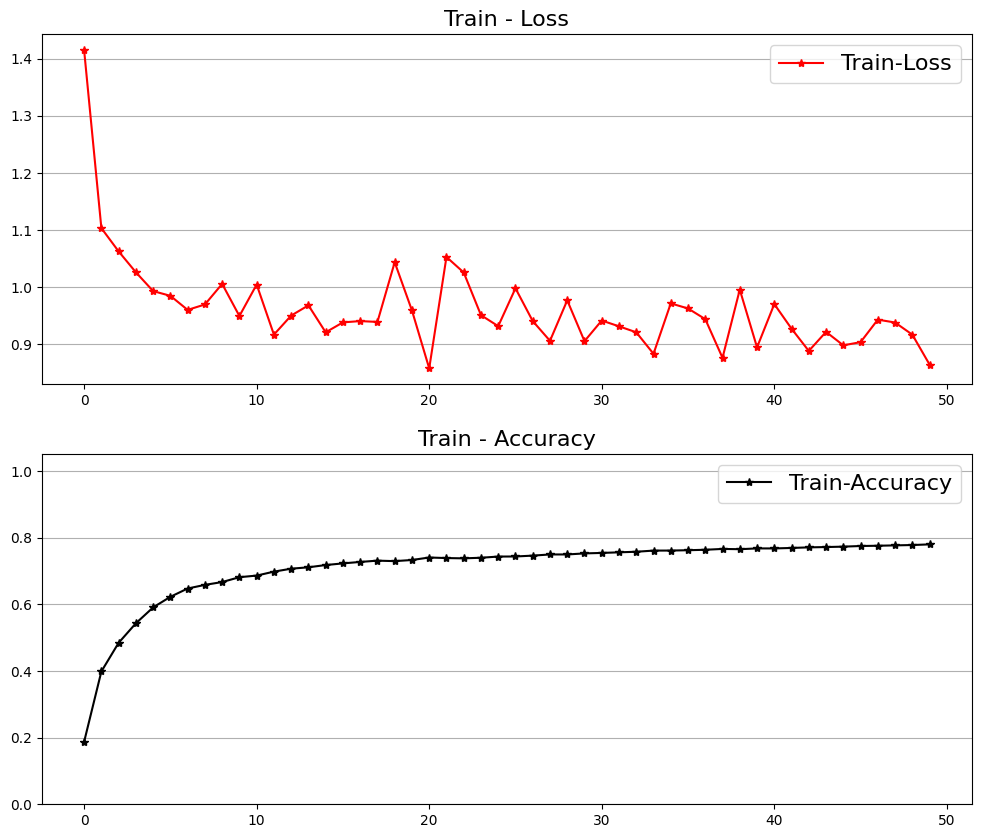

In [21]:
fig = plt.figure(figsize=[12, 10])
loss_plt = plt.subplot(2,1,1)
acc_plt = plt.subplot(2,1,2)

loss_plt.plot(loss_arr, color='red', marker="*")
loss_plt.set_title("Train - Loss", fontsize=16)
loss_plt.legend(['Train-Loss'], fontsize=16)
loss_plt.grid(True, axis='y')

acc_plt.plot(train_acc, color='black', marker="*")
acc_plt.set_title("Train - Accuracy", fontsize=16)
acc_plt.legend(['Train-Accuracy'], fontsize=16)
acc_plt.set_ylim((0.0, 1.05))
acc_plt.grid(True, axis='y')

plt.show()

### Model Evaluation

In [22]:
test_start = time.time()

model.eval()
with torch.no_grad():
    test_acc_tmp, test_precision_tmp, test_recall_tmp, test_f1_tmp = [], [], [], []
    for test_iter, (test_x, test_y_true) in enumerate(testloader):
        test_x, test_y_true = test_x.to(device), test_y_true.to(device)
        test_y_pred = model.forward(test_x)  # forward

        _, test_pred_index = torch.max(test_y_pred, 1)

        test_pred_index_cpu = test_pred_index.cpu().detach().numpy()
        test_y_true_cpu = test_y_true.cpu().detach().numpy()
            
        test_acc, test_precision, test_recall, test_f1 = get_clf_eval(test_y_true_cpu, test_pred_index_cpu)

        test_acc_tmp.append(test_acc), test_precision_tmp.append(test_precision), test_recall_tmp.append(test_recall), test_f1_tmp.append(test_f1)

    test_acc_mean = sum(test_acc_tmp, 0.0)/len(test_acc_tmp)
    test_precision_mean = sum(test_precision_tmp, 0.0)/len(test_precision_tmp)
    test_recall_mean = sum(test_recall_tmp, 0.0)/len(test_recall_tmp)
    test_f1_mean = sum(test_f1_tmp, 0.0)/len(test_f1_tmp)
    print("[Evaluation] {:.2f}[s], Test Accuracy : {:.4f}, Precision : {:.4f}, Recall : {:.4f}, F1 Score : {:.4f}".format(
        time.time()-test_start, test_acc_mean, test_precision_mean, test_recall_mean, test_f1_mean))
    print("[Model Performance] Model Performance : {:.5f}".format(test_acc_mean))

[Evaluation] 0.13[s], Test Accuracy : 0.8254, Precision : 0.8352, Recall : 0.8254, F1 Score : 0.8225
[Model Performance] Model Performance : 0.82537
